# Assignment 25
--------------------------------------------------------------------------------

### In this assignment we are going to train a GAN network with indian CAR data set of 100 x 100 which we created by downloading data from indian cars from google.

### Let's first download the dataset from google drive and unzip the dataset.

In [0]:
!pip install -U -q PyDrive
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


### Import important files

In [0]:
import zipfile
from google.colab import drive
#import the library opencv
import cv2
#globbing utility.
import glob
from skimage import io
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
from IPython.display import Image as _Imgdis
import os

### Important functions to download, extract, rename and resize images:

In [0]:
def Download_Images_from_Drive(FileName,DriveFilepath,TargetFolderName):
  drive_handler.download(FileName, target_path=DriveFilepath)
  zip_ref = zipfile.ZipFile(FileName, 'r')
  zip_ref.extractall(TargetFolderName)
  zip_ref.close()  

def Upload_Images_to_Drive(FileName,TargetDrivePath):
  drive_handler.upload(FileName, parent_path=TargetDrivePath)

def ReName_Multiple_Images(Imagepath,imgStartingName):
  import os
  # Function to rename multiple files 
  def main(): 
      i = 1
      for filename in os.listdir(Imagepath): 
          dst =imgStartingName + str("{0:04}".format(i)) + ".jpg"
          src =Imagepath+ filename 
          dst =Imagepath+ dst 

          # rename() function will 
          # rename all the files 
          os.rename(src, dst) 
          i += 1

  # Driver Code 
  if __name__ == '__main__':       
      # Calling main() function 
      main() 

def Resize_Images(imagePath,TargetSize):
  !mkdir 'RAW_Image_Resized'
  for bb,file in enumerate (glob.glob(imagePath)):
    img = io.imread(file)
    img = cv2.resize(img, dsize=(TargetSize, TargetSize), interpolation=cv2.INTER_CUBIC)
    #writing the images in a folder output_images
    cv2.imwrite('RAW_Image_Resized/car{}.jpg'.format("{0:04}".format(bb+1)), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    k = cv2.waitKey(1000)
    cv2.destroyAllWindows()  

def Read_Images(TargetPath):
  car_images = []
  #path = 'RAW_Image_Resized/*.*'
  #path = 'RAW_Image_Resized/RAW_Image_Resized/*.*'
  for bb,file in enumerate (glob.glob(TargetPath)):
    #print(file)
    img = io.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    car_images.append(img)
  car_images = np.asarray(car_images)
  return car_images


### Now let's download Images from Drive and store them in avariable

In [0]:
try:
  Download_Images_from_Drive('RAW_Image_Resized.zip','EVA_Phase_1/Session_25/RAW_Image_Resized.zip',"RAW_Image_Resized")
  car_images = Read_Images('RAW_Image_Resized/RAW_Image_Resized/*.*')
  print(car_images.shape)
except:
  Download_Images_from_Drive('All Images.zip','EVA_Phase_1/Session_25/All Images.zip','RAW_Image')
  ReName_Multiple_Images('RAW_Image/All Images/','car')
  Resize_Images('RAW_Image/All Images/*.*',100)
  !zip -r RAW_Image_Resized.zip RAW_Image_Resized
  Upload_Images_to_Drive('RAW_Image_Resized.zip','EVA_Phase_1/Session_25/')  
  car_images = Read_Images('RAW_Image_Resized/*.*')
  print(car_images.shape) 
# !rm 'RAW_Image_Resized.zip'
# !rm 'All Images.zip'
# !rm -rf RAW_Image_Resized
# !rm -rf RAW_Image  


(1000, 100, 100, 3)


### Now let's Import libraries required for training of DCGAN

In [0]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from time import time
import matplotlib.pyplot as plt

import sys

import numpy as np
!mkdir 'images_dcgan'

Using TensorFlow backend.


### Now let's write a class to train out DCGAN Network and let's train out DCGAN network

In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 100
        self.img_cols = 100
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256 * 6 * 6, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((6, 6, 256)))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))       
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu")) 
        model.add(ZeroPadding2D(padding=((0,1),(0,1)))) 
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))    , 
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))            
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25)) 
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))       
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, dataset, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = dataset

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        seconds_elapsed = 0
        for epoch in range(epochs):
            start_time = time()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # If at save interval => save generated image samples
            if epoch !=0:
              if epoch % save_interval == 0:
                  self.save_imgs(epoch)

            end_time = time()
            seconds_elapsed += end_time - start_time
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f] [Seconds Elapsed: %d]" % (epoch, d_loss[0], 100*d_loss[1], g_loss,seconds_elapsed))
      

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images_dcgan/car_gallery_%s.png" % "{0:05}".format(epoch))
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(car_images, epochs=50000, batch_size=64, save_interval=50)

### Now, let's visualize an image created by our GAN

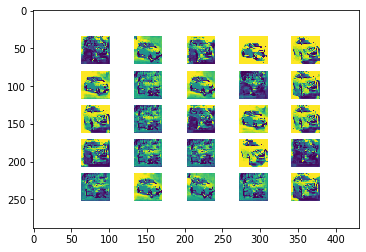

In [0]:
# !rm -rf 'images'
img = io.imread('images_dcgan/car_gallery_49950.png')
plt.imshow(img)

### Now le's create a video file of the generated images and upload the file to google drive:

In [0]:
def Write_Video(image_folder,video_name):
  import cv2
  import os
  images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
  frame = cv2.imread(os.path.join(image_folder, images[0]))
  height, width, layers = frame.shape

  video = cv2.VideoWriter(video_name, 0, 1, (width,height))

  for image in images:
      img = cv2.imread(os.path.join(image_folder, image))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      video.write(img)

  cv2.destroyAllWindows()
  video.release()
Video_file_name = 'DcGAN.mp4'
Write_Video('images_dcgan',Video_file_name)  
Upload_Images_to_Drive(Video_file_name,'EVA_Phase_1/Session_25/')

InvalidConfigError: ignored

In [0]:

# model = Sequential(layers=[
#     Conv2D(32, kernel_size=3, strides=2, input_shape=(100,100,3), padding="same"),
#     Conv2D(64, kernel_size=3, strides=2, padding="same"),
#     # ZeroPadding2D(padding=((0,1),(0,1))),
#     Conv2D(128, kernel_size=3, strides=2, padding="same"),
#     Conv2D(256, kernel_size=3, strides=2, padding="same"),
#     Conv2D(256, kernel_size=3, strides=2, padding="same"),
#     Flatten()
# ])
# for layer in model.layers:
#     print(layer.output_shape)